In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import defaultdict
from hashable import *

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def center_position(points):
    c = np.mean(points, axis=0)
    assert len(c) == len(points[0])
    return c

In [3]:
def som_step(centers,data,neighbor,eta,sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k**2, data.size)))**2,1))

    # find coordinates of the winner
    a,b = np.nonzero(neighbor == b)
        
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1,b1 = np.nonzero(neighbor==j)
        # calculate the distance and discounting factor
        disc=gauss(np.sqrt((a-a1)**2+(b-b1)**2),[0, sigma])
        # update weights        
        centers[j,:] += disc * eta * (data - centers[j,:])
        

In [4]:
def name2digits(name):
    """ takes a string NAME and converts it into a pseudo-random selection of 4
     digits from 0-9.
     
     Example:
     name2digits('Felipe Gerhard')
     returns: [0 4 5 7]
     """
    
    name = name.lower()
    
    if len(name)>25:
        name = name[0:25]
        
    primenumbers = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
    
    n = len(name)
    
    s = 0.0
    
    for i in range(n):
        s += primenumbers[i]*ord(name[i])*2.0**(i+1)

    import scipy.io.matlab
    Data = scipy.io.matlab.loadmat('hash.mat',struct_as_record=True)
    x = Data['x']
    t = np.mod(s,x.shape[0])

    return np.sort(x[t,:])

In [5]:
def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

In [6]:
def label_digits(data, labels, centers, targetdigits, size_k):
    # Initialize indexes and digits
    closest = 0
    digits = []
    # iterate over size of kohonen map
    for i in range(size_k**2):
            #find the index of the closest point to ith center
            closest = np.argmin(np.sum((data[:] - centers[i, :])**2, axis=1))
            digits.append(labels[closest])
    #Create a size_k*size_k matrix
    return np.reshape(digits, (size_k, size_k))

In [105]:
def plot_centers_heatmap(centers, size_k, title):
    plt.figure("centers"+str(title))
    plt.title(str(title))
    for i in range(size_k**2):
        plt.subplot(size_k,size_k,i+1)
        plt.axis('off')
        plt.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
    

In [117]:
def mse_err(centers, win):
    errs = np.zeros(len(centers))
    assert win < len(centers[0])-10
    
    for i in range(win, len(centers[0])-win-1):
        sl = centers[:, (i-win):(i+win)]
        errs = errs + ((np.sum(sl, axis=1) - centers[:, i])/(len(sl)-1) - centers[:, i])**2
    return errs 

In [144]:
def kohonen_test(max_iter=5, R=1, init_eta=0.1, movment_limit = 0.1, init_sigma=3.0, 
                 Wcmmean = 2000,
                 Wcmstd = 250,
                 plot_title="",
                 learning_rate_fun=lambda x: x, 
                 sigma_fun=lambda x, y: x,
                 data=None, labels=None, targetdigits=None, size_k=6):

    
    dim = 28*28
    data_range = 255.0
    
    # load in data and labels
    if data is None:
        data = np.array(np.loadtxt('data.txt'))
    if labels is None:
        labels = np.loadtxt('labels.txt')

    # select 4 digits
    if targetdigits is None:
        name = 'Josselin Vallée'
        targetdigits = name2digits(name) # assign the four digits that should be used
        
    print(targetdigits) # output the digits that were selected
    # this selects all data vectors that corresponds to one of the four digits
    data = data[np.logical_or.reduce([labels==x for x in targetdigits]),:]
    # select all the labels correponding to targetdigits
    labels = labels[np.logical_or.reduce([labels==x for x in targetdigits])]
    
    dy, dx = data.shape
    
    #set the size of the Kohonen map. In this case it will be 6 X 6
    #size_k = 6
    
    #set the width of the neighborhood via the width of the gaussian that
    #describes it
    sigma = init_sigma
    
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    
    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))

    #set the learning rate
    eta = init_eta
    
    #set the maximal iteration count
    tmax = max_iter
    
    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)
    
    # initialize previous center position
    prev_centers = np.copy(centers)
        
    c_m = defaultdict(lambda: [])
    c_m_mean = defaultdict(lambda: [])
    c_m_diff = defaultdict(lambda: [])
    c_m_std = defaultdict(lambda: [])
    
    c_m_array = np.zeros((len(centers), tmax))
    c_m_mean_array = np.zeros((len(centers), tmax))
    c_m_std_array = np.zeros((len(centers), tmax))
    cmmeanlen = 0
    cmstdlen = 0
    
    mse_array = np.zeros((len(centers), tmax))
    mse_mean_array = np.zeros((len(centers), tmax))
    mse_std_array = np.zeros((len(centers), tmax))
    mselen = 0
    msestdlen = 0

    
    #Initialisation of the eta and 
    eta_array = [(0, eta)]
    sigma_array = [(0, sigma)]
    
    do_stop = False
    T = -1
    reset_count = True
    do_stop_count = 0
    last_max = float('inf')
    for t, i in enumerate(i_random):
        
        T += 1
        #Copy the previous center position
        prev_centers = np.copy(centers)
        
        #Perform one step of the SOM
        som_step(centers, data[i,:],neighbor,eta,sigma)
        
        # update learning rate
        eta = learning_rate_fun(eta)
        if eta != eta_array[-1][1]:
            eta_array.append((t, eta))
        
        #update sigma
        sigma = sigma_fun(sigma, eta)
        if sigma != sigma_array[-1][1]:
            sigma_array.append((t, sigma))
        
        # center movement
        """
        diff_centers = centers - prev_centers
        norm_movments = np.linalg.norm(diff_centers, axis=1)
        c_m_array[:, t] = norm_movments
        
        #Window size
        if t > Wcmmean:
            c_m_mean_array[:, cmmeanlen] = np.mean(c_m_array[:, (t-Wcmmean):t], axis=1)
            cmmeanlen += 1
        
        reset_count = True
        
        if cmmeanlen > Wcmstd:
            stds = np.std(c_m_mean_array[:, (cmmeanlen-Wcmstd):cmmeanlen], axis=1)
            last_max = np.max(stds)
            reset_count = last_max > movment_limit
            c_m_std_array[:, cmstdlen] = stds 
            cmstdlen += 1
        """
        """
        # mse
        if t % 100 == 0:
            mse_centers = mse_err(centers, 10)
            mse_array[:, mselen] = mse_centers
            mselen += 1
        """
        
        
        """
        for i in range(0, len(norm_movments)):
            c_m[i].append(norm_movments[i])
        
        
        if t > Wcmmean:
            for i in range(0, len(c_m)):
                c_m_mean[i].append(np.mean(c_m[i][-Wcmmean:]))
        
        
        reset_count = True
        if len(c_m_mean[0]) > Wcmstd:
            reset_count = False
            for i in range(0, len(c_m_mean)):
                val = np.std(c_m_mean[i][-Wcmstd:])
                #val /= eta
                reset_count = reset_count or val > 0.011
                c_m_std[i].append(val)
        """
        """
        if reset_count:
            do_stop_count = 0
        else:
            do_stop_count += 1
        
        if do_stop_count > 2000:
            do_stop = True
        
        """
        # show stuff
        if t % 1000 == 998:
            print("\n", t, end="")
            print(" > sigma:", sigma, end="")
            print(" > eta:", eta, end="")
            #print(" > count:", do_stop_count, end="")
            #print(" > last_max:", last_max, end="")
            # print(" > mse:", mse_array[:, mselen-1])
            # plot_centers_heatmap(centers, size_k, "It:"+str(t))
            
                               
        if t % 100 == 0:
            print(".", end="")
        
        """
        # stopping criterias:
        last_x = 10
        if (len(center_movement_score) > last_x and sum([m_s < movment_limit for m_s in center_movement_score[-last_x:]]) == last_x):
            print('\nmovment limit reached')
            do_stop = True
        """
        
        if do_stop:
            print("\n converged at iteration", t)
            break
    
    print("Total iterations: ", T)
    """
    plt.figure("mse_array"+str(eta), figsize=(25, 10))
    plt.title("mse_array")
    plt.xlabel("iteration")
    plt.ylabel("mse")
    for i in range(0, len(centers)):
        plt.plot(mse_array[i, :mselen])
    """
    
    plt.figure("all_center_movements_mean"+plot_title, figsize=(25, 10))
   
    plt.figure("all_center_movements_mean"+str(eta), figsize=(25, 10))
    plt.title("center movements smoothed")
    plt.xlabel("iteration")
    plt.ylabel("L2 norm")
    for i in range(0, len(centers)):
        plt.plot(range(Wcmmean, Wcmmean+cmmeanlen), c_m_mean_array[i, :cmmeanlen])
    """
    for k, l in c_m_mean.items():
        plt.plot(l)
       """ 
    plt.figure("all_center_movements_std"+plot_title, figsize=(25, 10))
    plt.title("center movement score")
    plt.xlabel("iteration")
    plt.ylabel("score")
    for i in range(0, len(centers)):
        plt.plot(range(Wcmmean+Wcmstd, Wcmstd+Wcmmean+cmstdlen), c_m_std_array[i, :cmstdlen])
        
    """
    for k, l in c_m_std.items():
        plt.plot(l)
       """ 
    """
    plt.figure("mean_all_centers"+str(eta), figsize=(10, 7))
    plt.title("mean_all_centers"+str(eta))
    plt.plot(mean_all_centers)
    
    plt.figure("std_mean_all_centers"+str(eta), figsize=(10, 7))
    plt.title("std_mean_all_centers"+str(eta))
    plt.plot(std_mean_all_centers)
    """
    print(label_digits(data, labels, centers, targetdigits, size_k))
    
    
    plot_centers_heatmap(centers, size_k, "Final"+plot_title)
    
    plt.show()
    plt.draw()
        
    return {} 

150000

----------------------------------
F: 0.0001
[0, 1, 2, 5]
..........
 998 > sigma: 2.9500500000001164 > eta: 0.001..........
 1998 > sigma: 2.900050000000233 > eta: 0.001..........
 2998 > sigma: 2.8500500000003495 > eta: 0.001..........
 3998 > sigma: 2.800050000000466 > eta: 0.001..........
 4998 > sigma: 2.7500500000005825 > eta: 0.001..........
 5998 > sigma: 2.700050000000699 > eta: 0.001..........
 6998 > sigma: 2.6500500000008156 > eta: 0.001..........
 7998 > sigma: 2.600050000000932 > eta: 0.001..........
 8998 > sigma: 2.5500500000010486 > eta: 0.001..........
 9998 > sigma: 2.500050000001165 > eta: 0.001..........
 10998 > sigma: 2.4500500000012817 > eta: 0.001..........
 11998 > sigma: 2.4000500000013982 > eta: 0.001..........
 12998 > sigma: 2.3500500000015148 > eta: 0.001..........
 13998 > sigma: 2.3000500000016313 > eta: 0.001..........
 14998 > sigma: 2.250050000001748 > eta: 0.001..........
 15998 > sigma: 2.2000500000018643 > eta: 0.001..........
 16998 > sig

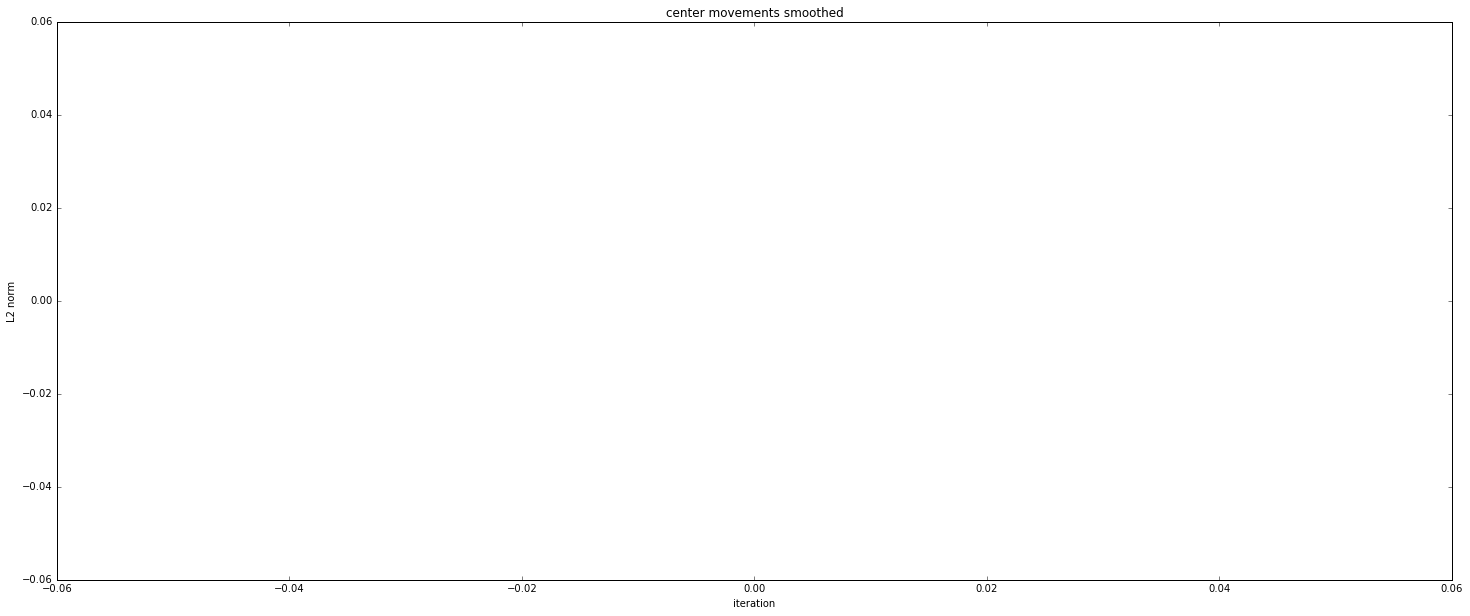

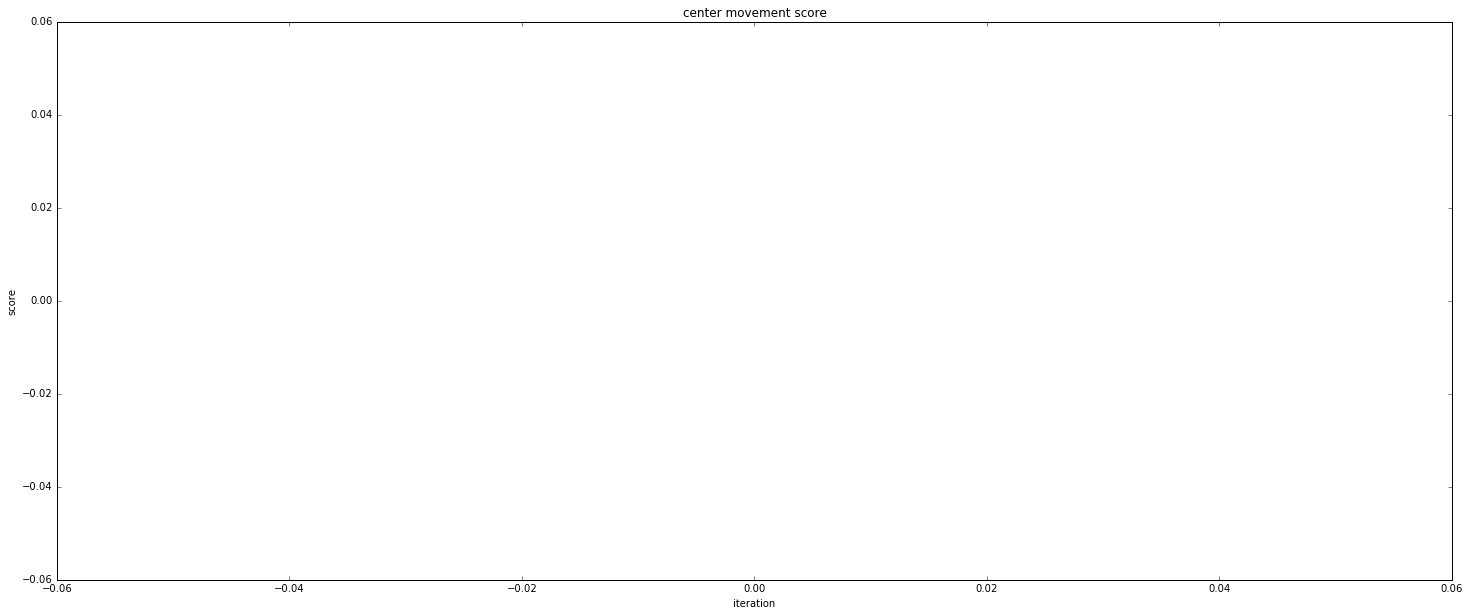

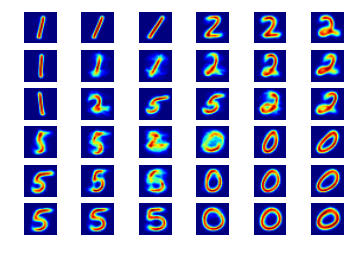

In [175]:
tmax = 150000
print(tmax)
decrease_factors = [0.0001]
figs = []
legends = defaultdict(lambda: [])
# load in data and labels
data = np.array(np.loadtxt('data.txt'))
labels = np.loadtxt('labels.txt')
targetdigits = [0, 1, 2, 5] #name2digits("Lukas Pestalozzi")

for f in decrease_factors:
    print("\n----------------------------------")
    print("F:", f)
    plt_dict = kohonen_test(max_iter=tmax, R=0, init_eta=0.001, init_sigma=3.0,
                                                    movment_limit = 0.000,
                                                    Wcmmean = 2000,
                                                    Wcmstd = 1500,
                                                    sigma_fun = lambda s, e: s-0.00005 if s > 1 else s*0.9999,
                                                    #learning_rate_fun = lambda e: e*0.9999,
                                                    plot_title=str(f),
                                                    targetdigits=targetdigits,
                                                    data=data, labels=labels)
    i = 0
    for k in sorted(plt_dict, key=lambda x: x[1]):
        if len(figs) <= i : 
            figs.append(plt.figure(str(i), figsize=(15, 10)))
            plt.title(k)
            #plt.ylim(0, 1)
            
        v = plt_dict[k]
        plt.figure(str(i))
        h, = plt.plot([x[0] for x in v], [x[1] for x in v])
        legends[i].append(h)
        i+=1
    
legnd = [str(e) for e in etas]
for i in range(0, len(figs)):
    plt.figure(str(i))
    plt.legend(legends[i], legnd, loc=1)
        

150000

----------------------------------
F: 0.0001
[0, 1, 2, 5]
..........
 998 > sigma: 3.9500500000001164 > eta: 0.9500500000000055..........
 1998 > sigma: 3.900050000000233 > eta: 0.900050000000011..........
 2998 > sigma: 3.8500500000003495 > eta: 0.8500500000000165..........
 3998 > sigma: 3.800050000000466 > eta: 0.800050000000022..........
 4998 > sigma: 3.7500500000005825 > eta: 0.7500500000000275..........
 5998 > sigma: 3.700050000000699 > eta: 0.700050000000033..........
 6998 > sigma: 3.6500500000008156 > eta: 0.6500500000000385..........
 7998 > sigma: 3.600050000000932 > eta: 0.600050000000044..........
 8998 > sigma: 3.5500500000010486 > eta: 0.5500500000000496..........
 9998 > sigma: 3.500050000001165 > eta: 0.5000500000000551..........
 10998 > sigma: 3.4500500000012817 > eta: 0.47561411652342034..........
 11998 > sigma: 3.4000500000013982 > eta: 0.4524175768038156..........
 12998 > sigma: 3.3500500000015148 > eta: 0.4303523732583689..........
 13998 > sigma: 3.3

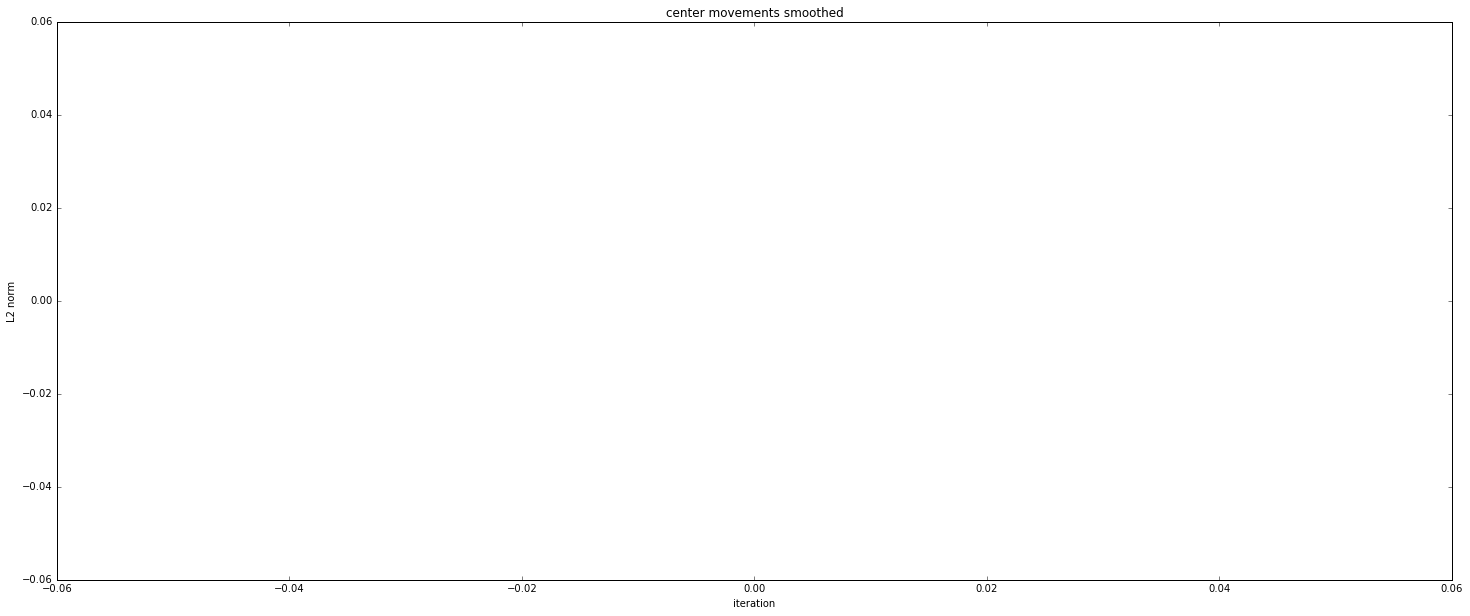

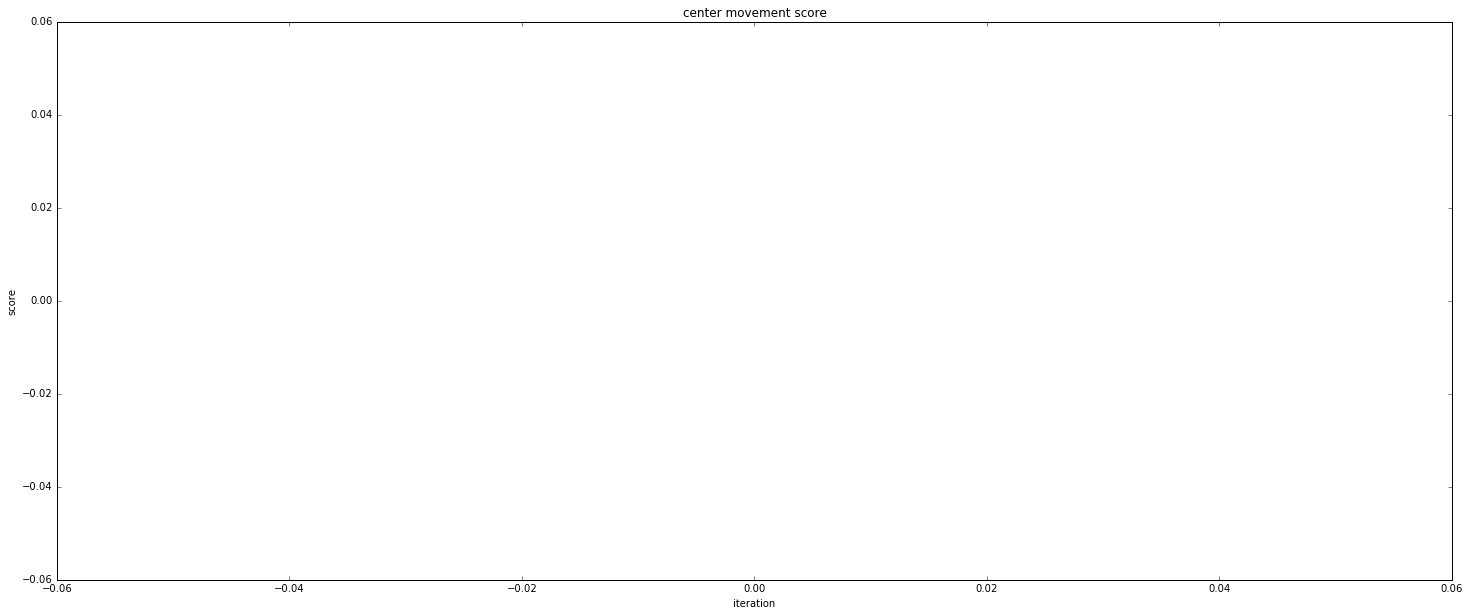

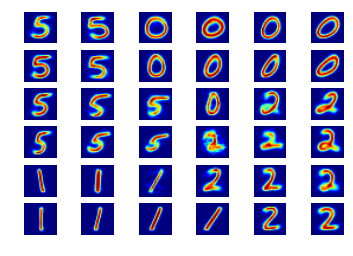

In [176]:
tmax = 150000
print(tmax)
decrease_factors = [0.0001]
figs = []
legends = defaultdict(lambda: [])
# load in data and labels
data = np.array(np.loadtxt('data.txt'))
labels = np.loadtxt('labels.txt')
targetdigits = [0, 1, 2, 5] #name2digits("Lukas Pestalozzi")

for f in decrease_factors:
    print("\n----------------------------------")
    print("F:", f)
    plt_dict = kohonen_test(max_iter=tmax, R=0, init_eta=1, init_sigma=4.0,
                                                    movment_limit = 0.000,
                                                    Wcmmean = 2000,
                                                    Wcmstd = 1500,
                                                    sigma_fun = lambda s, e: s-0.00005 if s > 1.8 else s*0.9999,
                                                    learning_rate_fun = lambda e: e-0.00005 if e > 0.5 else e*0.99995,
                                                    plot_title=str(f),
                                                    targetdigits=targetdigits,
                                                    data=data, labels=labels)
    i = 0
    for k in sorted(plt_dict, key=lambda x: x[1]):
        if len(figs) <= i : 
            figs.append(plt.figure(str(i), figsize=(15, 10)))
            plt.title(k)
            #plt.ylim(0, 1)
            
        v = plt_dict[k]
        plt.figure(str(i))
        h, = plt.plot([x[0] for x in v], [x[1] for x in v])
        legends[i].append(h)
        i+=1
    
#legnd = [str(e) for e in etas]
for i in range(0, len(figs)):
    plt.figure(str(i))
    plt.legend(legends[i], legnd, loc=1)
        